In [1]:
# Import necessary libraries
import sys
sys.path.append('../')

# Set the environment variable for MPS fallback
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import PIL.Image as Image
import torch
from torchvision import transforms
from scipy import ndimage
from detectron2.utils.colormap import random_color

import dino # model
from third_party.TokenCut.unsupervised_saliency_detection import metric, utils
from crf import densecrf

In [ ]:
from types import SimpleNamespace
args = SimpleNamespace(
    out_dir='',  # output directory
    vit_arch='small',  # which architecture, choices: ['base', 'small']
    vit_feat='k',  # which features, choices: ['k', 'q', 'v', 'kqv']
    patch_size=8,  # patch size, choices: [16, 8]
    img_path=None,  # single image visualization
    tau=0.15,  # threshold used for producing binary graph
    fixed_size=960,  # rescale the input images to a fixed size
    pretrain_path=None,  # path to pretrained model
    N=3,  # the maximum number of pseudo-masks per image
    backend='cpu',  # use cpu, cuda, mps
    output_path=''  # path to save outputs
)

print(args)

namespace(N=3, backend='cpu', fixed_size=480, img_path=None, out_dir='', output_path='', patch_size=8, pretrain_path=None, tau=0.15, vit_arch='small', vit_feat='k')


In [3]:
# Load pretrained model
if args.pretrain_path is not None:
    url = args.pretrain_path
if args.vit_arch == 'base' and args.patch_size == 8:
    if args.pretrain_path is None:
        url = "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    feat_dim = 768
elif args.vit_arch == 'small' and args.patch_size == 8:
    if args.pretrain_path is None:
        url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"
    feat_dim = 384

backbone = dino.ViTFeat(url, feat_dim, args.vit_arch, args.vit_feat, args.patch_size)

msg = 'Load {} pre-trained feature...'.format(args.vit_arch)
print(msg)
backbone.eval()
# if args.backend == 'cuda':
backbone = backbone.to(args.backend)
    

Loading weight from https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth
Load small pre-trained feature...


In [5]:
# args.img_path = 'imgs/demo3.jpg'
# args.img_path = '../../../data/hpimit/082621/Image_71.tif'
args.img_path = '../../../data/hpimit/082621/CHO-on-PEDOT_110620_2.tif'

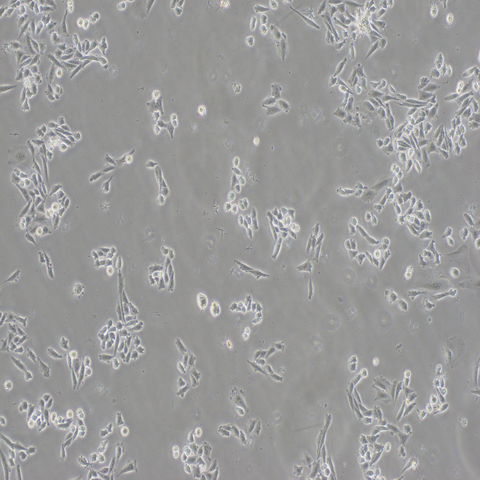

In [6]:
# Resize image to fixed size
I = Image.open(args.img_path).convert('RGB')

I_new = I.resize((int(args.fixed_size), int(args.fixed_size)), Image.LANCZOS)
I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, args.patch_size)

display(I_resize)

In [7]:
# Image transformation applied to all images 
ToTensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    ),
])

# Use dino ViTFeat to extract features from the image
tensor = ToTensor(I_resize).unsqueeze(0).to(args.backend)
# if not args.cpu: tensor = tensor.cuda()

feat = backbone(tensor)[0]

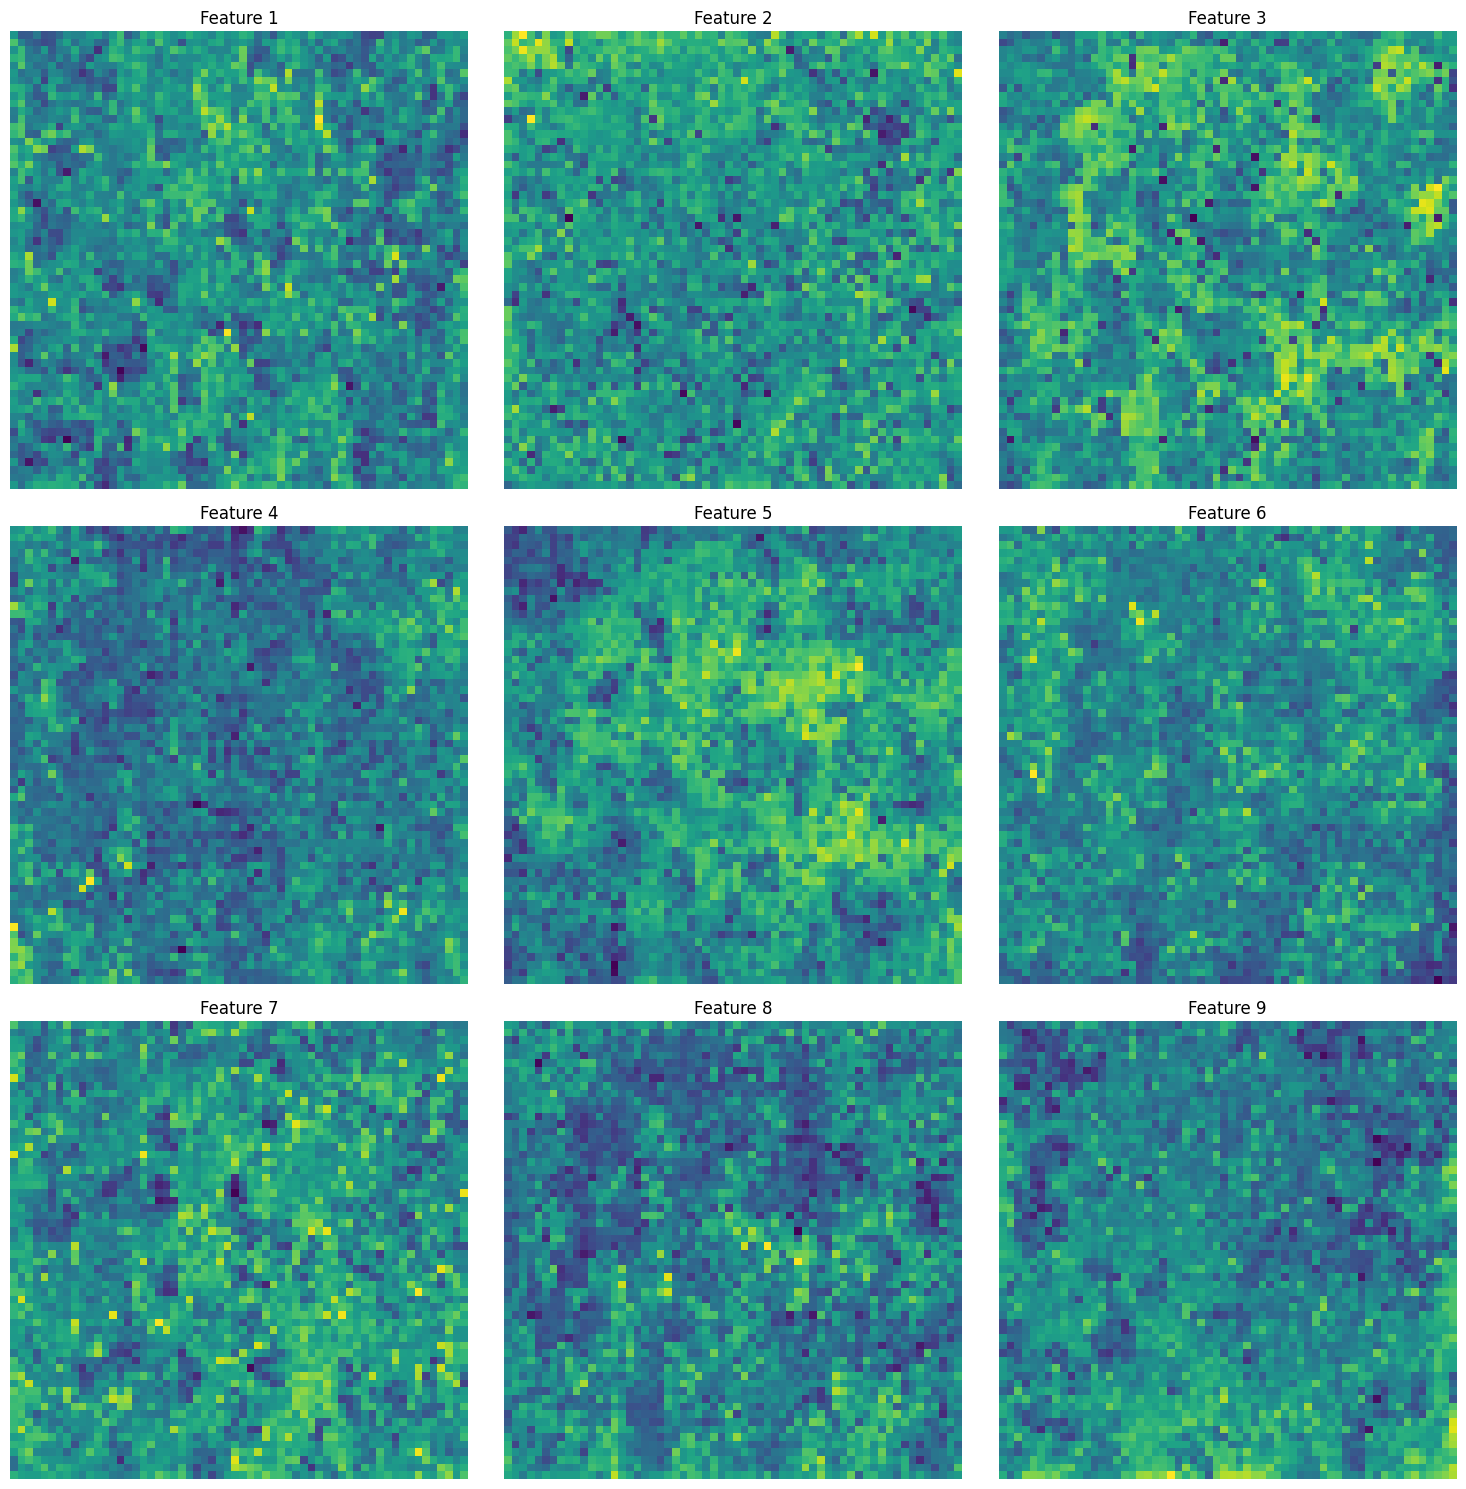

In [8]:
import matplotlib.pyplot as plt

feat_np = feat.detach().cpu().numpy()

# Reshape the features if necessary
# For example, if the features are flattened, reshape them to [C, H, W]
num_channels = feat_np.shape[0]
feat_size = int(np.sqrt(feat_np.shape[1]))  # Assuming the features are square
feat_np = feat_np.reshape(num_channels, feat_size, feat_size)

# Select a few feature maps to visualize
num_features_to_visualize = 9  # Number of feature maps to visualize
grid_size = int(np.ceil(np.sqrt(num_features_to_visualize)))  # Determine grid size

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for i in range(num_features_to_visualize):
    ax = axes[i // grid_size, i % grid_size]
    ax.imshow(feat_np[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Feature {i+1}')

# Hide any unused subplots
for j in range(num_features_to_visualize, grid_size * grid_size):
    fig.delaxes(axes[j // grid_size, j % grid_size])

plt.tight_layout()
plt.show()

In [8]:
from maskcut import maskcut_forward

bipartitions, eigvecs = [], []
_, bipartition, eigvec = maskcut_forward(feat, [feat_h, feat_w], [args.patch_size, args.patch_size], [h,w], args.tau, N=args.N, backend=args.backend)

bipartitions += bipartition
eigvecs += eigvec

: 

: 

In [ ]:
# Process image and generate pseudo masks
width, height = I.size
pseudo_mask_list = []
for idx, bipartition in enumerate(bipartitions):
    # post-process pseudo-masks with CRF
    pseudo_mask = densecrf(np.array(I_new), bipartition)
    pseudo_mask = ndimage.binary_fill_holes(pseudo_mask >= 0.5)

    # filter out the mask that have a very different pseudo-mask after the CRF
    mask1 = torch.from_numpy(bipartition).to(args.backend)
    mask2 = torch.from_numpy(pseudo_mask).to(args.backend)
        
    if metric.IoU(mask1, mask2) < 0.5:
        pseudo_mask = pseudo_mask * -1

    # construct binary pseudo-masks
    pseudo_mask[pseudo_mask < 0] = 0
    pseudo_mask = Image.fromarray(np.uint8(pseudo_mask * 255))
    pseudo_mask = np.asarray(pseudo_mask.resize((width, height)))

    pseudo_mask = pseudo_mask.astype(np.uint8)
    upper = np.max(pseudo_mask)
    lower = np.min(pseudo_mask)
    thresh = upper / 2.0
    pseudo_mask[pseudo_mask > thresh] = upper
    pseudo_mask[pseudo_mask <= thresh] = lower
    pseudo_mask_list.append(pseudo_mask)
    
len(pseudo_mask_list)
# test if any mask is empty
empty = 0
for mask in pseudo_mask_list:
    if np.sum(mask) == 0:
        empty += 1
        
print(f'Empty masks: {empty}/{len(pseudo_mask_list)}')

Empty masks: 3/3


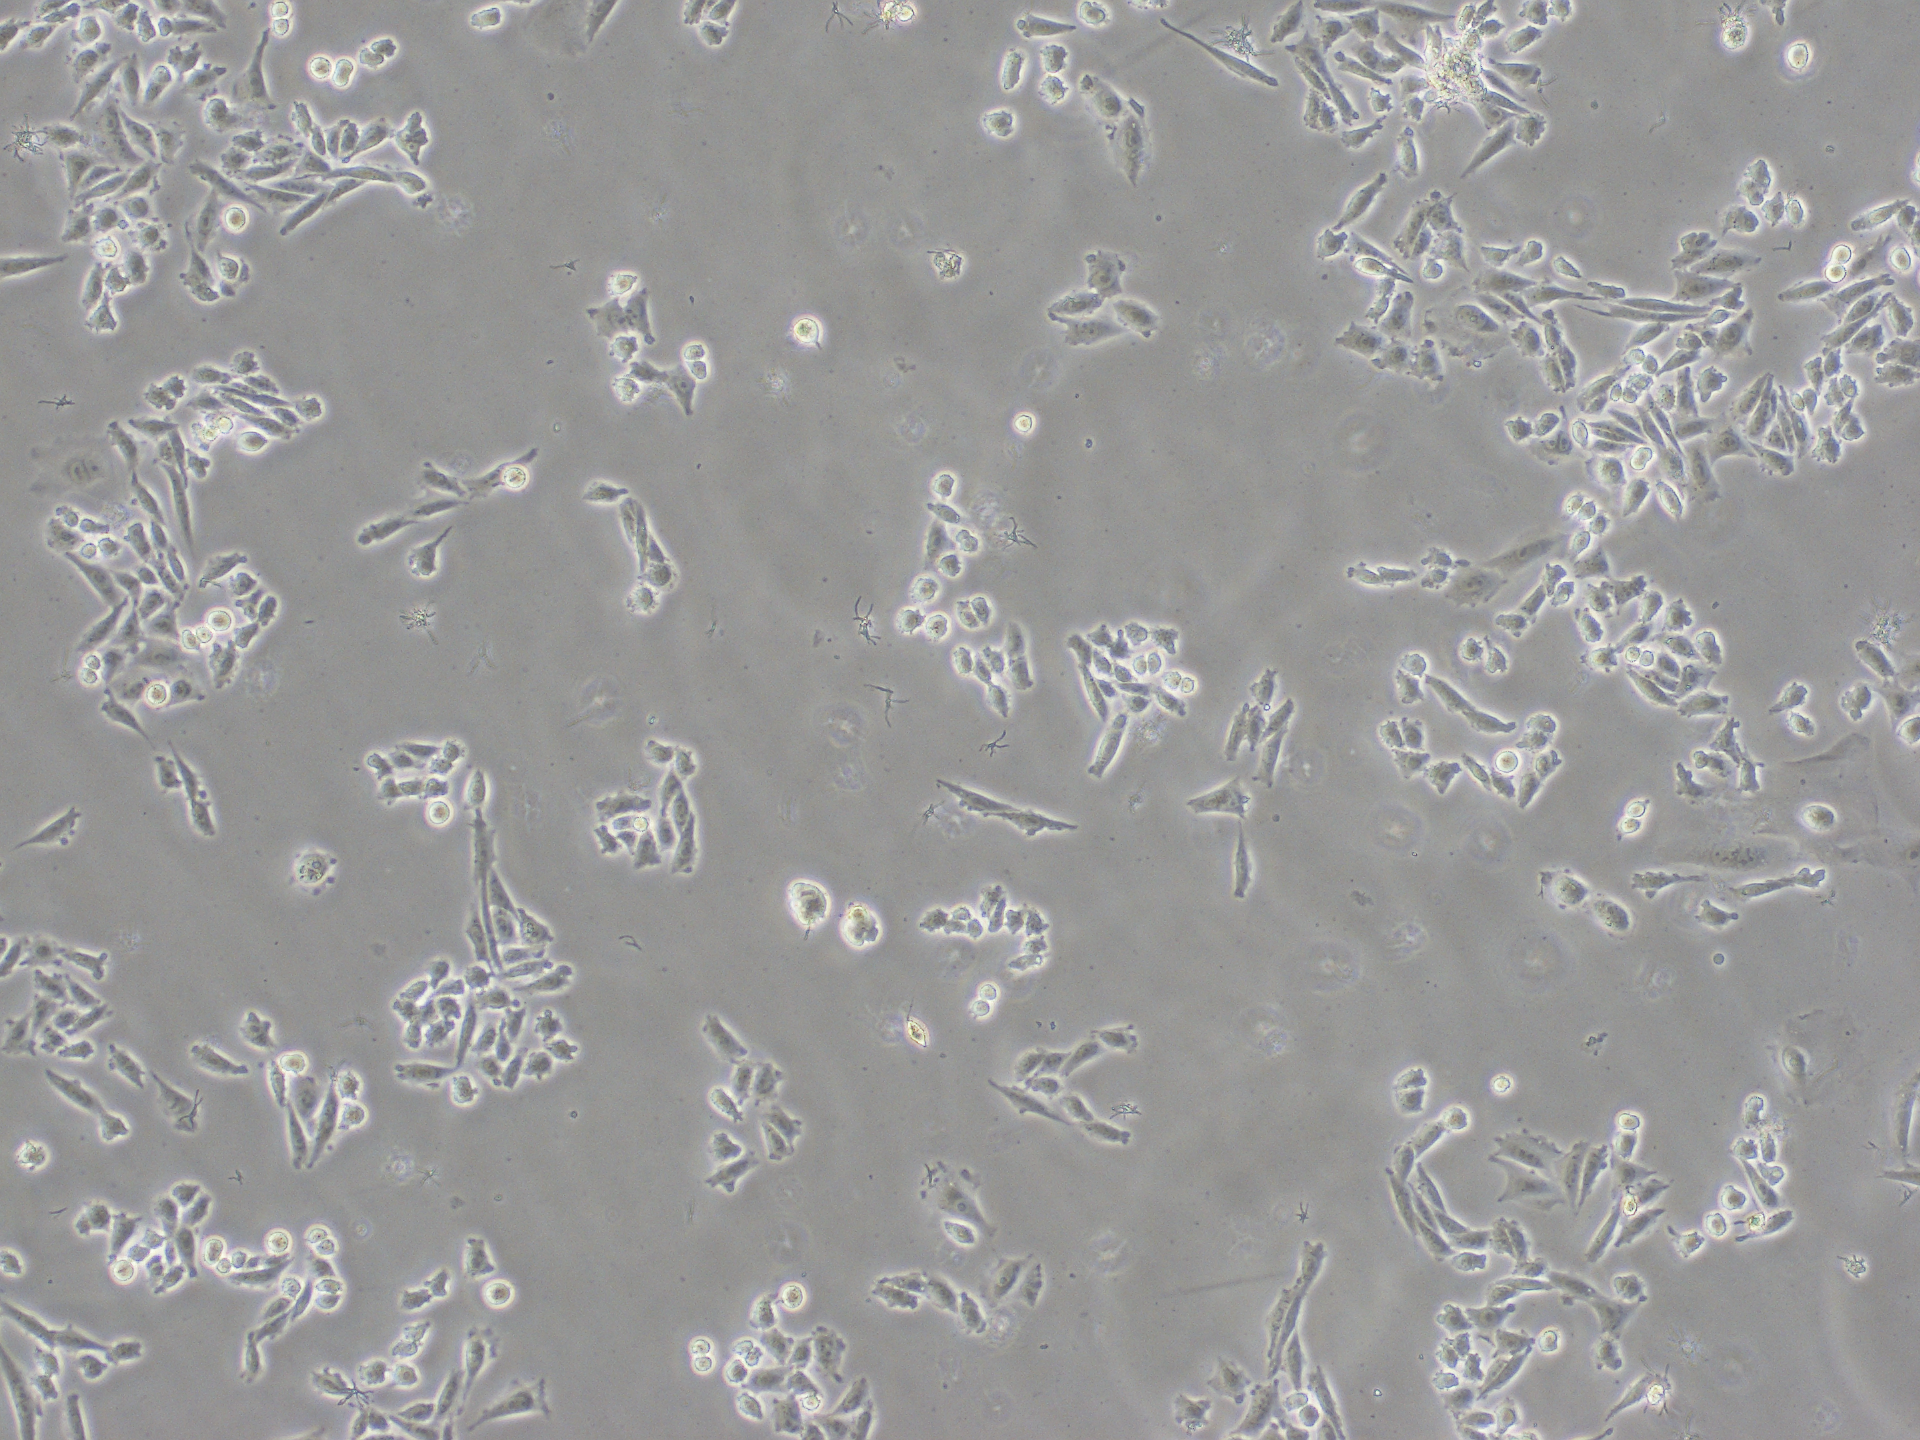

In [ ]:
def vis_mask(input, mask, mask_color):
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.3 + np.array(mask_color) * 0.7).astype(np.uint8)
    return Image.fromarray(rgb)

# Visualize results by overlaying pseudo masks on the input image
input = np.array(I)
for pseudo_mask in pseudo_mask_list:
    input = vis_mask(input, pseudo_mask, random_color(rgb=True))


display(input)